# PDE Modelling Mimic of 190413 experiment

## Objectives 
* Microscope movie was performed on 190413 that simply observed growth of a constitutively fluorescent strain on agar pads, varying in pad size and cell occupation
* Simulate each of the experimental setups executed
* eventually build into a fitting routine

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


In [8]:
# imports
from __future__ import division, print_function

import itertools as itt

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi

import matplotlib as mpl
mpl.use("Agg")
# import seaborn as sns
import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext line_profiler
import timeit

# import bokeh
# from bokeh.plotting import figure, output_file, save
# from bokeh.io import output_notebook, show
# from bokeh import palettes, transform
# from bokeh.models import LogColorMapper, LogTicker, ColorBar, LinearColorMapper, Ticker
# output_notebook()

from IPython.display import HTML

# rc = {'lines.linewidth': 2, 
#       'axes.labelsize': 18, 
#       'axes.titlesize': 24, 
#       'xtick.labelsize': 18, 
#       'ytick.labelsize': 18, 
#       'legend.fontsize': 18,
#       'axes.facecolor': 'DFDFE5'}

# sns.set_context('paper', rc=rc)

%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [2]:
#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

# @numba.jit
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0, dims, calc_f):
    species, n_h, n_w, scale= dims
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    y.shape = species*n_h*n_w
    return d_y.flatten()


In [5]:

def wrapper(dims, p0, initial_array, tmax, atol, rtol, calc_f):
    species, n_h, n_w, scale = dims
    args=(np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((species, n_h, n_w), dtype=np.float32,order='C'), 
          np.zeros((n_h, n_w), dtype=np.float32,order='C'), 
          p0, dims, calc_f)
    initial_array.shape = n_h*n_w*species
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    out = itg.solve_ivp(f_lambda, [0, tmax], initial_array, vectorized=True, method='RK45', 
                        atol=atol, rtol=rtol, t_eval=np.arange(tmax))
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
    return exp_y, exp_t

def prep_pad_helper(scale, init_cells):
    scale_factor = (scale/4500)/(2.475/4)
    scaled_init = skimage.transform.rescale((init_cells>1).astype(np.float32), 
                                            scale_factor, 
                                            order=1, 
                                            mode='constant', 
                                            multichannel=False,
                                            cval=0)
    return scaled_init
    
def prep_pad_0(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_0_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init
    
def prep_pad_1(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    # middle colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_1_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # top colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_10_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((0, n_w-s_w))//2)
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init
    
def prep_pad_2(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_2_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init
    
def prep_pad_3(scale):
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_3_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    # first colony
    y0, x0 = np.array((n_h//2 - s_h//2, n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # duplicate on the opposite side for the second colony
    y0, x0 = np.array((n_h//2 - s_h//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init


def prep_pad_4(scale):
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_4_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = (np.array((n_h, n_w))//2) - np.array((s_h, s_w))//2
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init

    
def prep_pad_5(scale):
    n_h, n_w = (5*scale,5*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    # left colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_5_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, scale//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    # right colony
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_6_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, 6*n_w//8))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init

    
def prep_pad_6(scale):
    n_h, n_w = (5*scale,5*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_7_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, scale//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init
    
def prep_pad_7(scale):
    n_h, n_w = (3*scale,3*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_8_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init
    
def prep_pad_8(scale):
    n_h, n_w = (2*scale,2*scale)
    cell_init = np.zeros((n_h, n_w), dtype=np.float32)
    img_fn = '../../../microscope-movie-analysis/worker_outputs/masks/pad_9_frame_5.tif'
    init_cells = skimage.io.imread(img_fn)
    scaled_init = prep_pad_helper(scale, init_cells)
    s_h, s_w = scaled_init.shape
    y0, x0 = np.array(((n_h-s_h)//2, (n_w-s_w)//2))
    y1, x1 = np.array((y0,x0)) + np.array((s_h, s_w))
    y0, y1, x0, x1 = np.array((y0, y1, x0, x1), dtype=np.int)
    cell_init[y0:y1,x0:x1] = scaled_init
    return cell_init

def sim_pad_prep(p0, scale, tmax, prep_fn):
    # Calculate dx and redefine p0
    Dc, Dn, rc, Kn, Hn, pn, xs, ps, leak, od0 = p0
    dx = np.power((scale/4.5),2)
    p0 = np.array([dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps, leak, od0])
    
    # Prep initial array
    cell_init = prep_fn(scale).astype(np.float32)
    n_h, n_w = cell_init.shape
    col_thresh = 0.05
    species = 3 # cells, nutrients, mscarlet
    dims = [species, n_h, n_w, scale]
    c_i, n_i, s_i = np.arange(species)
    
    # Make empty array, and tolerance arrays
    atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    atol[c_i,:,:] = 1e-3*np.ones((n_h, n_w), dtype=np.float32)
    atol[n_i,:,:] = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    atol[s_i,:,:] = 1e-2*np.ones((n_h, n_w), dtype=np.float32)
    # atol must be a vector for the solver
    atol.shape = species*n_h*n_w
    rtol = 1e-3
    
    # Set initial conditions
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    initial_array[c_i,:,:] = cell_init*od0
    initial_array[s_i,:,:] = np.greater(cell_init, col_thresh)*(xs/(rc+ps))
    
#     @numba.jit(cache=True)
    def calc_f(y, d_y, diff_terms, nut_avail, p0):
        dx, Dc, Dn, rc, Kn, Hn, pn, xs, ps, leak, od = p0
        calc_diffusion(y, diff_terms)

        # Nutrient term
        nut_avail[:,:] = hill(y[n_i,:,:], Hn, Kn)

        # Cell growth and diffusion
        d_y[c_i,:,:] = (dx)*Dc*diff_terms[c_i,:,:] + rc * nut_avail * y[c_i,:,:]

        # Nutrient consumption
        d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - pn * nut_avail * y[c_i,:,:]

        # Synthase production
        d_y[s_i,:,:] = (xs * np.greater(y[c_i,:,:],col_thresh) - rc * y[s_i,:,:]) * nut_avail - ps * y[s_i,:,:]

    return dims, p0, initial_array, tmax, atol, rtol, calc_f

def sim_pad(p0, scale, tmax, prep_fn):
    return wrapper(*sim_pad_prep(p0, scale, tmax, prep_fn))
    

In [4]:
c_i, n_i, s_i = np.arange(3)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(1,3, figsize=(10,7))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    indxs = [c_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    indxs = [s_i]
    v_arr = im_arr[:,indxs,:,w//2:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [c_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
    fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


In [12]:
plt.close('all')
scale = np.power(2,3).astype(np.int)
tmax = 10*60

#Params :         Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0
p0 = np.array([1e-5, 3e-1, 2e-2, 75, 2, 1, 1e-8, 8e-3, 5e2, 1], dtype=np.float32)

# Define parameter values to sample
Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0 = p0
dc_vec = [1e-5]
dn_vec = [1e-1,7e-2,5e-2]
rc_vec = [2e-2]
kn_vec = [75]
hn_vec = [2]
pn_vec = [5,10]
xs_vec = [1e-8]
ps_vec = [8e-3]
leak_vec = [5e2]
od0_vec = [10]
parm_vecs = [dc_vec ,dn_vec ,rc_vec ,kn_vec ,hn_vec ,pn_vec ,xs_vec ,ps_vec ,leak_vec ,od0_vec]
# pad_fns = [prep_pad_0,prep_pad_1,prep_pad_2,prep_pad_3,prep_pad_4,prep_pad_5,prep_pad_6,prep_pad_7,prep_pad_8]
pad_fns = [prep_pad_0,prep_pad_4,prep_pad_5,prep_pad_6]

# Create sim parameter and pad data frame
columns = ['Dc' ,'Dn' ,'rc' ,'Kn' ,'Hn' ,'pn' ,'xs' ,'ps' ,'leak' ,'od0']
data = itt.product(*parm_vecs)
p0_df = pd.DataFrame(data, columns=columns)

sim_df = pd.DataFrame(itt.product(p0_df.index.values, np.arange(len(pad_fns))), columns=['p_ind','pad_ind'])

print(sim_df.shape)

def worker(sim_df):
    for sim_ind in sim_df.index:
        pad_ind = sim_df.loc[sim_ind,'pad_ind']
        p0_ind = sim_df.loc[sim_ind,'p_ind']
        pad_fn = pad_fns[pad_ind]
        p0 = p0_df.loc[p0_ind,:].values
        out = sim_pad(p0, scale, tmax, pad_fn)
        np.save('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind), out[0])
        np.save('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind), out[1])
#             anim = write_movie(out[0], out[1])
#             anim.save('worker_outputs/animation_pad{}_p{}.gif'.format(pad_ind,p0_ind), writer='pillow')    
    
jobs = []
n_proc = 12
for i in range(n_proc):
    p = Process(target=worker, args=(sim_df[i::n_proc].copy(),))
    jobs.append(p)
    p.start()

for job in jobs:
    job.join()


(24, 2)


In [13]:

npy_file_list = ['worker_outputs/'+xx for xx in os.listdir('./worker_outputs') if 'npy' in xx]
pad_fns = [prep_pad_0,prep_pad_1,prep_pad_2,prep_pad_3,prep_pad_4,prep_pad_5,prep_pad_6,prep_pad_7,prep_pad_8]
for p0_ind in p0_df.index:
    p0 = p0_df.loc[p0_ind,:].values
    for pad_ind, pad_fn in enumerate(pad_fns):
        tvec_file = 'worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind)
        avec_file = 'worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind)
        if (tvec_file in npy_file_list) and (avec_file in npy_file_list):
            p0_df.loc[p0_ind,'pad{}_avec_fn'.format(pad_ind)] = avec_file
            p0_df.loc[p0_ind,'pad{}_tvec_fn'.format(pad_ind)] = tvec_file
        else:
            p0_df.loc[p0_ind,'pad{}_avec_fn'.format(pad_ind)] = 'na'
            p0_df.loc[p0_ind,'pad{}_tvec_fn'.format(pad_ind)] = 'na'
            

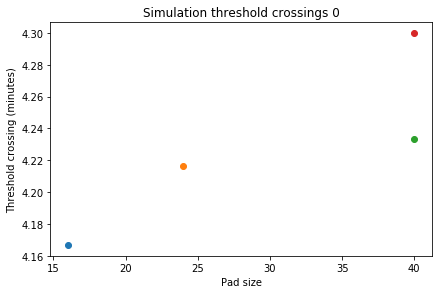

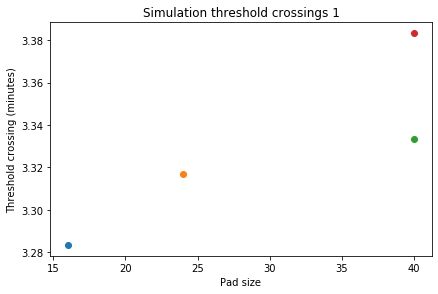

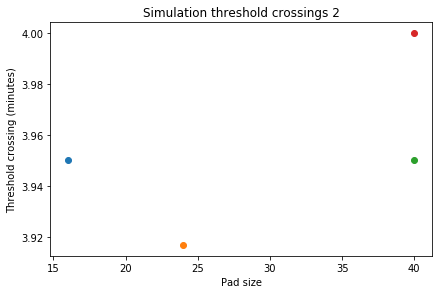

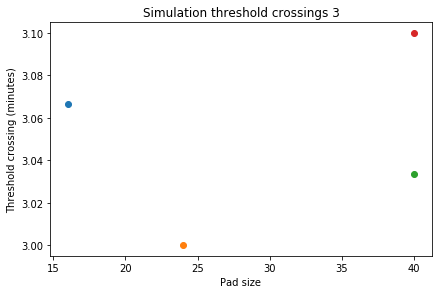

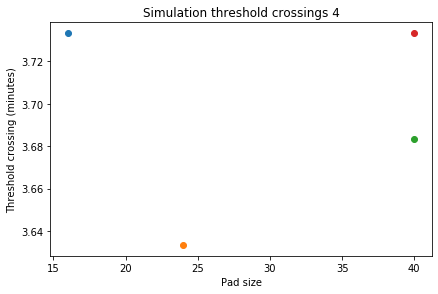

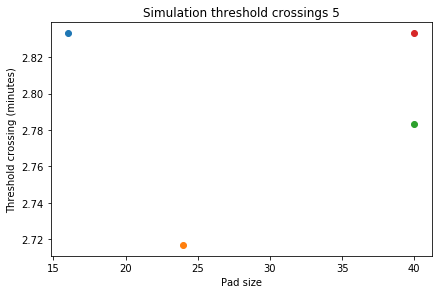

In [14]:
plt.close('all')
pad_size = []
gb_p = sim_df.groupby('p_ind')
for p0_ind in p0_df.index:
    plt.figure()
    sub_df = gb_p.get_group(p0_ind)
    for pad_ind in sub_df.pad_ind.values:
        tvec_fn, avec_fn = p0_df.loc[p0_ind, ['pad{}_avec_fn'.format(pad_ind), 'pad{}_tvec_fn'.format(pad_ind)]]
        if 'na' in [tvec_fn, avec_fn]:
            pass
        else:
            img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind))
            t_vec = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind))
        #     plt.figure()
        #     dy_vec = (np.diff(img[:,c_i,:,:],axis=0)/img[1:,c_i,:,:]).flatten('F')
            c_vec = img[:,c_i,:,:].sum(axis=-1).sum(axis=-1)
            dy_vec = np.diff(c_vec)/np.diff(t_vec)/c_vec[:-1]
            tc_ind = np.arange(len(dy_vec))[dy_vec<0.8*dy_vec.max()]
            if len(tc_ind) == 0:
                tc_ind = len(dy_vec)-1
            else:
                tc_ind = tc_ind[0]
        #     dy_t_vec = np.tile(t_vec[1:], len(dy_vec)//len(t_vec[1:]))
            plt.plot(img.shape[2], t_vec[tc_ind]/60,'o',label=pad_ind)
            plt.title('Simulation threshold crossings {}'.format(p0_ind))
#     plt.legend()
    plt.tight_layout()
    plt.xlabel('Pad size')
    plt.ylabel('Threshold crossing (minutes)')
#     plt.ylim([-1,3])


In [15]:
p0_df

,Dc,Dn,rc,Kn,Hn,pn,xs,ps,leak,od0,...,pad4_avec_fn,pad4_tvec_fn,pad5_avec_fn,pad5_tvec_fn,pad6_avec_fn,pad6_tvec_fn,pad7_avec_fn,pad7_tvec_fn,pad8_avec_fn,pad8_tvec_fn
0,0.00001,0.10,0.02,75,2,5,1.000000e-08,0.008,500.0,10,...,worker_outputs/pad4_p0_arr.npy,worker_outputs/pad4_p0_tvc.npy,worker_outputs/pad5_p0_arr.npy,worker_outputs/pad5_p0_tvc.npy,worker_outputs/pad6_p0_arr.npy,worker_outputs/pad6_p0_tvc.npy,worker_outputs/pad7_p0_arr.npy,worker_outputs/pad7_p0_tvc.npy,worker_outputs/pad8_p0_arr.npy,worker_outputs/pad8_p0_tvc.npy
1,0.00001,0.10,0.02,75,2,10,1.000000e-08,0.008,500.0,10,...,worker_outputs/pad4_p1_arr.npy,worker_outputs/pad4_p1_tvc.npy,worker_outputs/pad5_p1_arr.npy,worker_outputs/pad5_p1_tvc.npy,worker_outputs/pad6_p1_arr.npy,worker_outputs/pad6_p1_tvc.npy,worker_outputs/pad7_p1_arr.npy,worker_outputs/pad7_p1_tvc.npy,worker_outputs/pad8_p1_arr.npy,worker_outputs/pad8_p1_tvc.npy
2,0.00001,0.07,0.02,75,2,5,1.000000e-08,0.008,500.0,10,...,worker_outputs/pad4_p2_arr.npy,worker_outputs/pad4_p2_tvc.npy,worker_outputs/pad5_p2_arr.npy,worker_outputs/pad5_p2_tvc.npy,worker_outputs/pad6_p2_arr.npy,worker_outputs/pad6_p2_tvc.npy,worker_outputs/pad7_p2_arr.npy,worker_outputs/pad7_p2_tvc.npy,worker_outputs/pad8_p2_arr.npy,worker_outputs/pad8_p2_tvc.npy
3,0.00001,0.07,0.02,75,2,10,1.000000e-08,0.008,500.0,10,...,worker_outputs/pad4_p3_arr.npy,worker_outputs/pad4_p3_tvc.npy,worker_outputs/pad5_p3_arr.npy,worker_outputs/pad5_p3_tvc.npy,worker_outputs/pad6_p3_arr.npy,worker_outputs/pad6_p3_tvc.npy,worker_outputs/pad7_p3_arr.npy,worker_outputs/pad7_p3_tvc.npy,worker_outputs/pad8_p3_arr.npy,worker_outputs/pad8_p3_tvc.npy
4,0.00001,0.05,0.02,75,2,5,1.000000e-08,0.008,500.0,10,...,worker_outputs/pad4_p4_arr.npy,worker_outputs/pad4_p4_tvc.npy,worker_outputs/pad5_p4_arr.npy,worker_outputs/pad5_p4_tvc.npy,worker_outputs/pad6_p4_arr.npy,worker_outputs/pad6_p4_tvc.npy,worker_outputs/pad7_p4_arr.npy,worker_outputs/pad7_p4_tvc.npy,worker_outputs/pad8_p4_arr.npy,worker_outputs/pad8_p4_tvc.npy
5,0.00001,0.05,0.02,75,2,10,1.000000e-08,0.008,500.0,10,...,worker_outputs/pad4_p5_arr.npy,worker_outputs/pad4_p5_tvc.npy,worker_outputs/pad5_p5_arr.npy,worker_outputs/pad5_p5_tvc.npy,worker_outputs/pad6_p5_arr.npy,worker_outputs/pad6_p5_tvc.npy,worker_outputs/pad7_p5_arr.npy,worker_outputs/pad7_p5_tvc.npy,worker_outputs/pad8_p5_arr.npy,worker_outputs/pad8_p5_tvc.npy


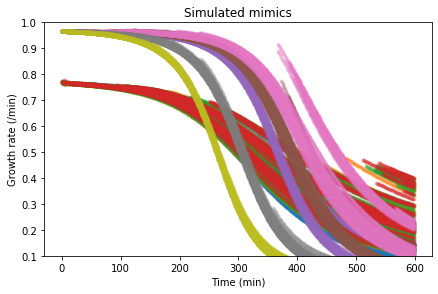

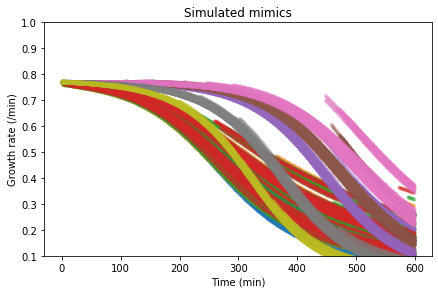

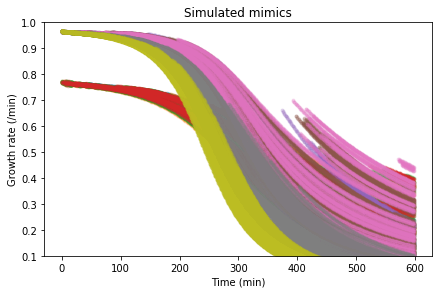

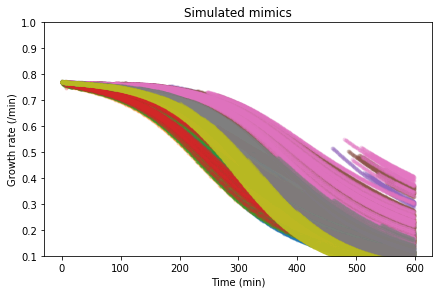

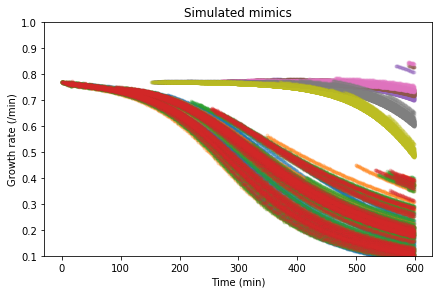

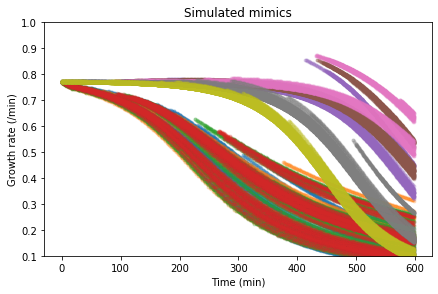

In [16]:
for p0_ind in p0_df.index:
    plt.figure()
    for pad_ind in range(9):
        img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind))
        n_t, _, n_h, n_w = img.shape
        t_vec = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind))
    #     plt.figure()
    #     dy_vec = (np.diff(img[:,c_i,:,:],axis=0)/img[1:,c_i,:,:]).flatten('F')
        c_vec = img[:,c_i,:,:]
        c_vec_nz = c_vec.copy()
        c_vec_nz[c_vec<0.05] = np.inf
        dt_vec = np.diff(t_vec).reshape((n_t-1,1,1))
        t_vec_rep = t_vec[:-1].repeat(n_h*n_w)
        dy_vec = np.diff(c_vec,axis=0)/c_vec_nz[:-1,:,:]/dt_vec
    #     dy_t_vec = np.tile(t_vec[1:], len(dy_vec)//len(t_vec[1:]))
        plt.plot(t_vec_rep, 60*dy_vec.flatten(),'.',label=pad_ind,alpha=0.2)
        plt.title('Simulated mimics')
#     plt.legend()
    plt.tight_layout()
    plt.xlabel('Time (min)')
    plt.ylabel('Growth rate (/min)')
    plt.ylim([0.1,1])
#     plt.legend()
#     plt.ylim([-1,3])

In [10]:
for p0_ind in [13]:
    plt.figure()
    for pad_ind in range(9):
        img = np.load('worker_outputs/pad{}_p{}_arr.npy'.format(pad_ind, p0_ind))
        t_vec = np.load('worker_outputs/pad{}_p{}_tvc.npy'.format(pad_ind, p0_ind))
    #     plt.figure()
    #     dy_vec = (np.diff(img[:,c_i,:,:],axis=0)/img[1:,c_i,:,:]).flatten('F')
        c_vec = img[:,c_i,:,:].sum(axis=-1).sum(axis=-1)
        dy_vec = np.diff(c_vec)/np.diff(t_vec)/c_vec[:-1]
    #     dy_t_vec = np.tile(t_vec[1:], len(dy_vec)//len(t_vec[1:]))
        plt.plot(t_vec[1:], dy_vec,'o',label=pad_ind)
        plt.title('Simulated mimics')
#     plt.legend()
    plt.tight_layout()
    plt.xlabel('Time (min)')
    plt.ylabel('Growth rate (/min)')
#     plt.legend()
#     plt.ylim([-1,3])

FileNotFoundError: [Errno 2] No such file or directory: 'worker_outputs/pad0_p13_arr.npy'

<Figure size 432x288 with 0 Axes>

In [44]:
c_i, n_i, s_i = np.arange(3)
def anim_sim(p0, scale, t_points, pad_fn):
    
    out = sim_pad_prep(p0, scale, t_points[-1], pad_fn)
    dims, p0, initial_array, tmax, atol, rtol, calc_f = out
    
    y = initial_array.copy().astype(np.float)
    d_y = np.zeros(y.shape, dtype=np.float64)
    diff_terms = np.zeros(y.shape, dtype=np.float64)
    nut_avail = np.zeros(y.shape[1:], dtype=np.float64)
    
    s, h, w, _ = dims
    frames = len(t_points)
    f_points = np.arange(frames)
    
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(1,3, figsize=(10,7))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    indxs = c_i
    vmax = 2
    vmin = -2
    arr = np.log10(initial_array[indxs,:,:]+1e-3)
    im = ax.imshow(arr, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    indxs = n_i
    vmax = 100
    vmin = 0
    im = ax.imshow(initial_array[indxs,:,:], animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    indxs = s_i
#     v_arr = im_arr[:,indxs,:,w//2:].prod(axis=1)
    vmax = 3
    vmin = -3
    arr = np.log10(initial_array[indxs,:,:]+1e-3)
    im = ax.imshow(arr, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im

    # animation function.  This is called sequentially
    t_i = t_points[0]
    
    def animate(frame):
        if frame==0:
            return
        
        t_j = t_points[frame]
        t_i = t_points[frame-1]
        dt = t_j - t_i
        calc_f(y, d_y, diff_terms, nut_avail, p0)
        y[:,:,:] = y+dt*d_y
        
        # Plot cell densities
        ax = axs[0]
        indxs = c_i
        frame_arr = np.log10(y[indxs,:,:]+1e-3)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = n_i
        frame_arr = y[indxs,:,:]
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = s_i
        frame_arr = np.log10(y[indxs,:,:]+1e-3)
        im_list[2].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=f_points)

#     anim.save('./animation_test.gif', writer='pillow')
    fig.tight_layout()
    plt.close('all')
    return anim

scale = np.power(2,5).astype(np.int)
tmax = 1

#Params :         Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0
p0 = np.array([1e-5, 3e-1, 2e-2, 75, 2, 1, 1e-8, 8e-3, 5e2, 1], dtype=np.float32)

anim = anim_sim(p0, scale, np.arange(0,tmax,0.0005), prep_pad_0)
HTML(anim.to_html5_video())


In [50]:
c_i, n_i, s_i = np.arange(3)
scale = np.power(2,8).astype(np.int)
tmax = 1
# t_points = np.arange(0,tmax,0.000005)

#Params :         Dc, Dn,    rc, Kn, Hn, pn, xs,   ps, leak, od0
p0 = np.array([1e-5, 3e-1, 2e-2, 75, 2, 1, 1e-8, 8e-3, 5e2, 1], dtype=np.float32)

out = sim_pad_prep(p0, scale, t_points[-1], prep_pad_0)
dims, p0, initial_array, tmax, atol, rtol, calc_f = out

y = initial_array.copy()
d_y = initial_array.copy()
diff_terms = np.zeros(y.shape, dtype=np.float32)
nut_avail = np.zeros(y.shape[1:], dtype=np.float32)
%timeit calc_f(y, d_y, diff_terms, nut_avail, p0)


16.2 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit 

0.0009481481481481482